In [102]:
! pip install torchview

^C
ERROR: Operation cancelled by user


In [103]:
import random
import os
import glob
import time
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
import torch.optim.lr_scheduler as lr_scheduler

from torch import nn
from torch.utils.data import (Dataset, DataLoader)
from torchvision import transforms
from torchinfo import summary
from torchview import draw_graph

import albumentations as A
from albumentations.pytorch import ToTensorV2

from PIL import Image
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, precision_recall_fscore_support,
    accuracy_score, f1_score, matthews_corrcoef, 
    confusion_matrix, ConfusionMatrixDisplay
)

plt.style.use("dark_background")

In [104]:
#Declaration des parametres generaux
class CFG:
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    NUM_DEVICES = torch.cuda.device_count()
    NUM_WORKERS = os.cpu_count()
    
    NUM_CLASSES = 2
    EPOCHS = 100
    BATCH_SIZE = (
        32 if torch.cuda.device_count() < 2 
        else (32 * torch.cuda.device_count())
    )
    LR = 1e-4
    PATIENS = 8
    
    APPLY_SHUFFLE = True
    SEED = 768
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_SIZE = (224, 224, 3)
    
    # Define paths
    DATASET_PATH = "/kaggle/input/lgg-mri-segmentation/"
    TRAIN_PATH = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/'
    
# Mute warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [105]:
%%time
#lecture des images du dataset
dataset_images = glob.glob(f"{CFG.TRAIN_PATH}**/*.tif")

CPU times: user 28.8 ms, sys: 5.94 ms, total: 34.7 ms
Wall time: 76.7 ms


<a id='1.2'></a>
### Create Pandas DataFrames for images and masks

In [106]:
#recuperation du ID du patient (teddi deux 9bel la feuille oumbaed teddi assm le dernier sous repertoire comme ID)
def get_sample_patient_id(image_paths):
    return [(_.split('/')[-2:][0]) for _ in image_paths]

#recuperation du ID du patient (teddi deux 9bel la feuille oumbaed teddi assm la feuille ida 
#l9at fiha 'mask.tif' alors c'est un mask twid 1 l la table, sinon tzid 0)
def get_sample_number(image_paths):
    sample_numbers = []
    is_mask = []
    
    for path in image_paths:
        path_list = path.split('/')[-2:][1].split('_')
#teddi le numero avant dernier avant extention, cest juste kelmet masque hiya hadak l wahed zyada mabin les masks et images
        if 'mask.tif' in path_list:
            sample_numbers.append(int(path_list[-2]))
            is_mask.append(1)
        else:
            sample_numbers.append(int(path_list[-1].replace('.tif', '')))
            is_mask.append(0)
            
    return sample_numbers, is_mask


def build_df(image_paths):
    sample_numbers, mask_label = get_sample_number(image_paths)
    # Create dataframe
    df = pd.DataFrame({
        'id'        : sample_numbers,
        'patient'   : get_sample_patient_id(image_paths),
        'image_path': image_paths,
        'is_mask'   : mask_label
    })
    
    # Return df
    return df

In [107]:
dataset_df = (
    build_df(dataset_images)
    .sort_values(by=['id', 'patient', 'image_path'])
    .reset_index(drop=True)
)

dataset_df

,id,patient,image_path,is_mask
0,1,TCGA_CS_4941_19960909,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1,1,TCGA_CS_4941_19960909,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
2,1,TCGA_CS_4942_19970222,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3,1,TCGA_CS_4942_19970222,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
4,1,TCGA_CS_4943_20000902,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
...,...,...,...,...
7853,87,TCGA_HT_A61B_19991127,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
7854,88,TCGA_HT_A61A_20000127,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
7855,88,TCGA_HT_A61A_20000127,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
7856,88,TCGA_HT_A61B_19991127,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0


In [108]:
# Group Samples by mask status
grouped_df = dataset_df.groupby(by='is_mask')

# Seperate Images from Masks
images_df, mask_df = (
    grouped_df.get_group(0).drop('is_mask', axis=1).reset_index(drop=True), 
    grouped_df.get_group(1).drop('is_mask', axis=1).reset_index(drop=True)
)

# Rename path column in mask df
mask_df = mask_df.rename({'image_path': 'mask_path'}, axis=1)

# View mask df
mask_df

,id,patient,mask_path
0,1,TCGA_CS_4941_19960909,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,1,TCGA_CS_4942_19970222,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,1,TCGA_CS_4943_20000902,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,1,TCGA_CS_4944_20010208,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,1,TCGA_CS_5393_19990606,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
...,...,...,...
3924,86,TCGA_HT_A61B_19991127,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3925,87,TCGA_HT_A61A_20000127,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3926,87,TCGA_HT_A61B_19991127,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3927,88,TCGA_HT_A61A_20000127,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [109]:
images_df

,id,patient,image_path
0,1,TCGA_CS_4941_19960909,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,1,TCGA_CS_4942_19970222,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,1,TCGA_CS_4943_20000902,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,1,TCGA_CS_4944_20010208,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,1,TCGA_CS_5393_19990606,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
...,...,...,...
3924,86,TCGA_HT_A61B_19991127,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3925,87,TCGA_HT_A61A_20000127,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3926,87,TCGA_HT_A61B_19991127,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3927,88,TCGA_HT_A61A_20000127,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [110]:
#conversion vers array (tensor optionnel), hadik 255 cest besh tahsser les pixels mabin 0 et 1
def _load(image_path, as_tensor=True):
    image = Image.open(image_path)
    return np.array(image).astype(np.float32) / 255.


def generate_label(mask_path, load_fn):
    mask = load_fn(mask_path)
    if mask.max() > 0:
        return 1 # Brain Tumor Present
    return 0 # Normal

In [113]:
# Merge images and mask df's
ds = images_df.merge(
    mask_df,
    on=['id', 'patient'],
    how='left'
)

# Generate MRI Label
ds['diagnosis'] = [generate_label(_, _load) for _ in tqdm(ds['mask_path'])]
ds

  0%|          | 0/3929 [00:00<?, ?it/s]

,id,patient,image_path,mask_path,diagnosis
0,1,TCGA_CS_4941_19960909,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1,1,TCGA_CS_4942_19970222,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,1,TCGA_CS_4943_20000902,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3,1,TCGA_CS_4944_20010208,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
4,1,TCGA_CS_5393_19990606,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
...,...,...,...,...,...
3924,86,TCGA_HT_A61B_19991127,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3925,87,TCGA_HT_A61A_20000127,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3926,87,TCGA_HT_A61B_19991127,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3927,88,TCGA_HT_A61A_20000127,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


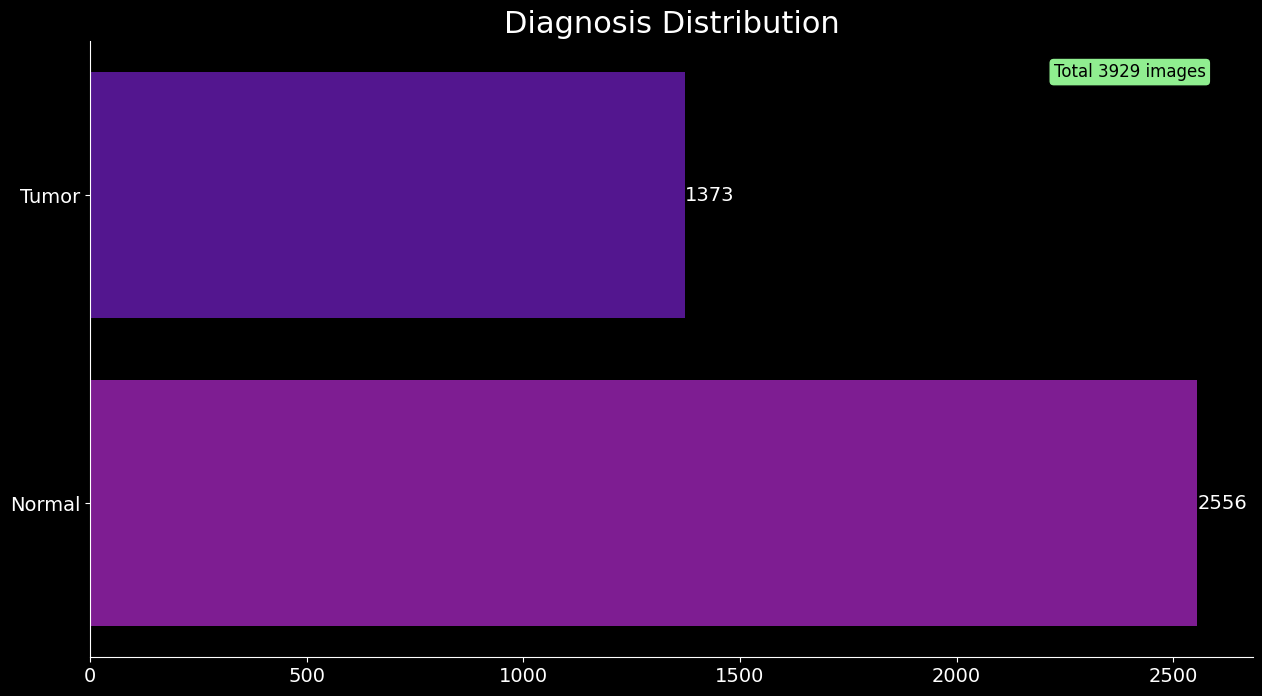

In [114]:
# View Diagnosis Distribution
fig = plt.figure(figsize=(15, 8))
plt.title('Diagnosis Distribution', fontsize=22);

diagnosis_distribution = ds['diagnosis'].value_counts().sort_values()
diagnosis_map = {0: 'Normal', 1: 'Tumor'}

bar_plot = sns.barplot(
    x=diagnosis_distribution.values,
    y=[diagnosis_map[_] for _ in diagnosis_distribution.keys()],
    palette=sns.color_palette("plasma"),
    orient="h"
);

for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.0f', fontsize=14);
    
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

text_params = {
    'x'       : 2400,
    'y'       : -0.4,
    's'       : f"Total {len(ds)} images", 
    'size'    : 12,
    'color'   : "black",
    'ha'      : "center", 
    'va'      : "center",
    'bbox'    : dict(boxstyle="round", fc=("lightgreen"),ec=("black"))
}
plt.text(**text_params);

sns.despine();

<a id='1.3'></a>
### Load & View Random Sample

In [115]:
def view_sample(image, mask, color_map='rgb', fig_size=(16, 8), title_size=18):
    fig = plt.figure(figsize=fig_size);
    fig.tight_layout();
    fig.subplots_adjust(top=0.95);
    
    # Plot MRI Image
    plt.subplot(1, 3, 1);
    plt.title(f'MRI Image', fontsize=title_size)
    if color_map=='rgb':
        plt.imshow(image)
    else:
        plt.imshow(image, cmap=color_map)
        
    # Plot Mask
    plt.subplot(1, 3, 2);
    plt.title(f'Mask', fontsize=title_size)
    plt.imshow(mask, cmap='gray');
    
    # Plot MRI w. Mask 
    plt.subplot(1, 3, 3);
    plt.title(f'MRI + Mask', fontsize=title_size)
    if color_map=='rgb':
        plt.imshow(image)
    else:
        plt.imshow(image, cmap=color_map)
        
    plt.imshow(mask, cmap='gray', alpha=0.5);
    
    return

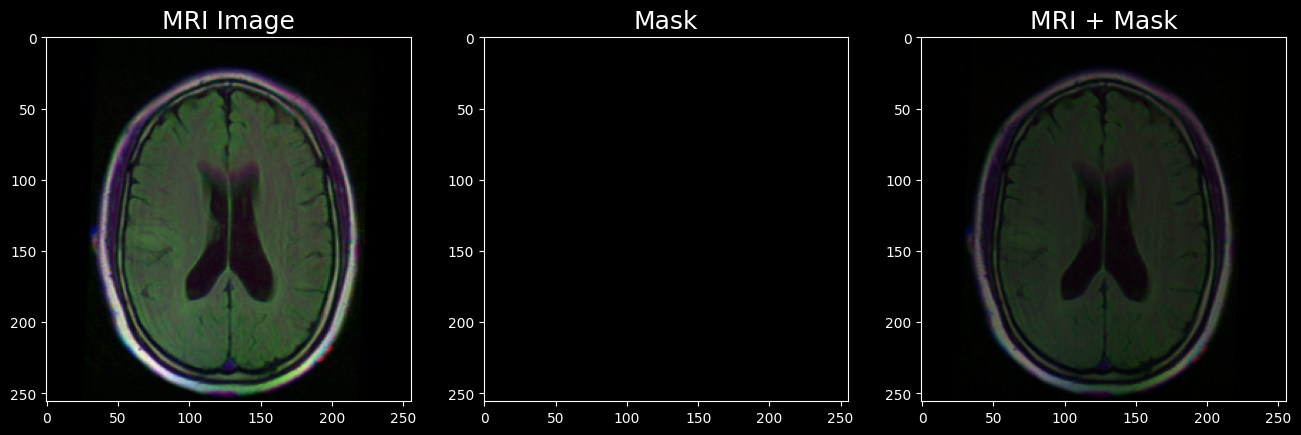

In [116]:
# Select random sample from train_df
#kheyret id randomized
idx = random.sample(ds.index.to_list(), 1)[0]

# Load the random sample and label
#jebna l'image et le mask li tab3in lel id aleatoire
sample_image, sample_mask = _load(ds.image_path[idx]), _load(ds.mask_path[idx])

# View the random sample
view_sample(
    sample_image,
    sample_mask,
    color_map='mako',
)

<a id='1.4'></a>
### Load & View Multiple Random Samples

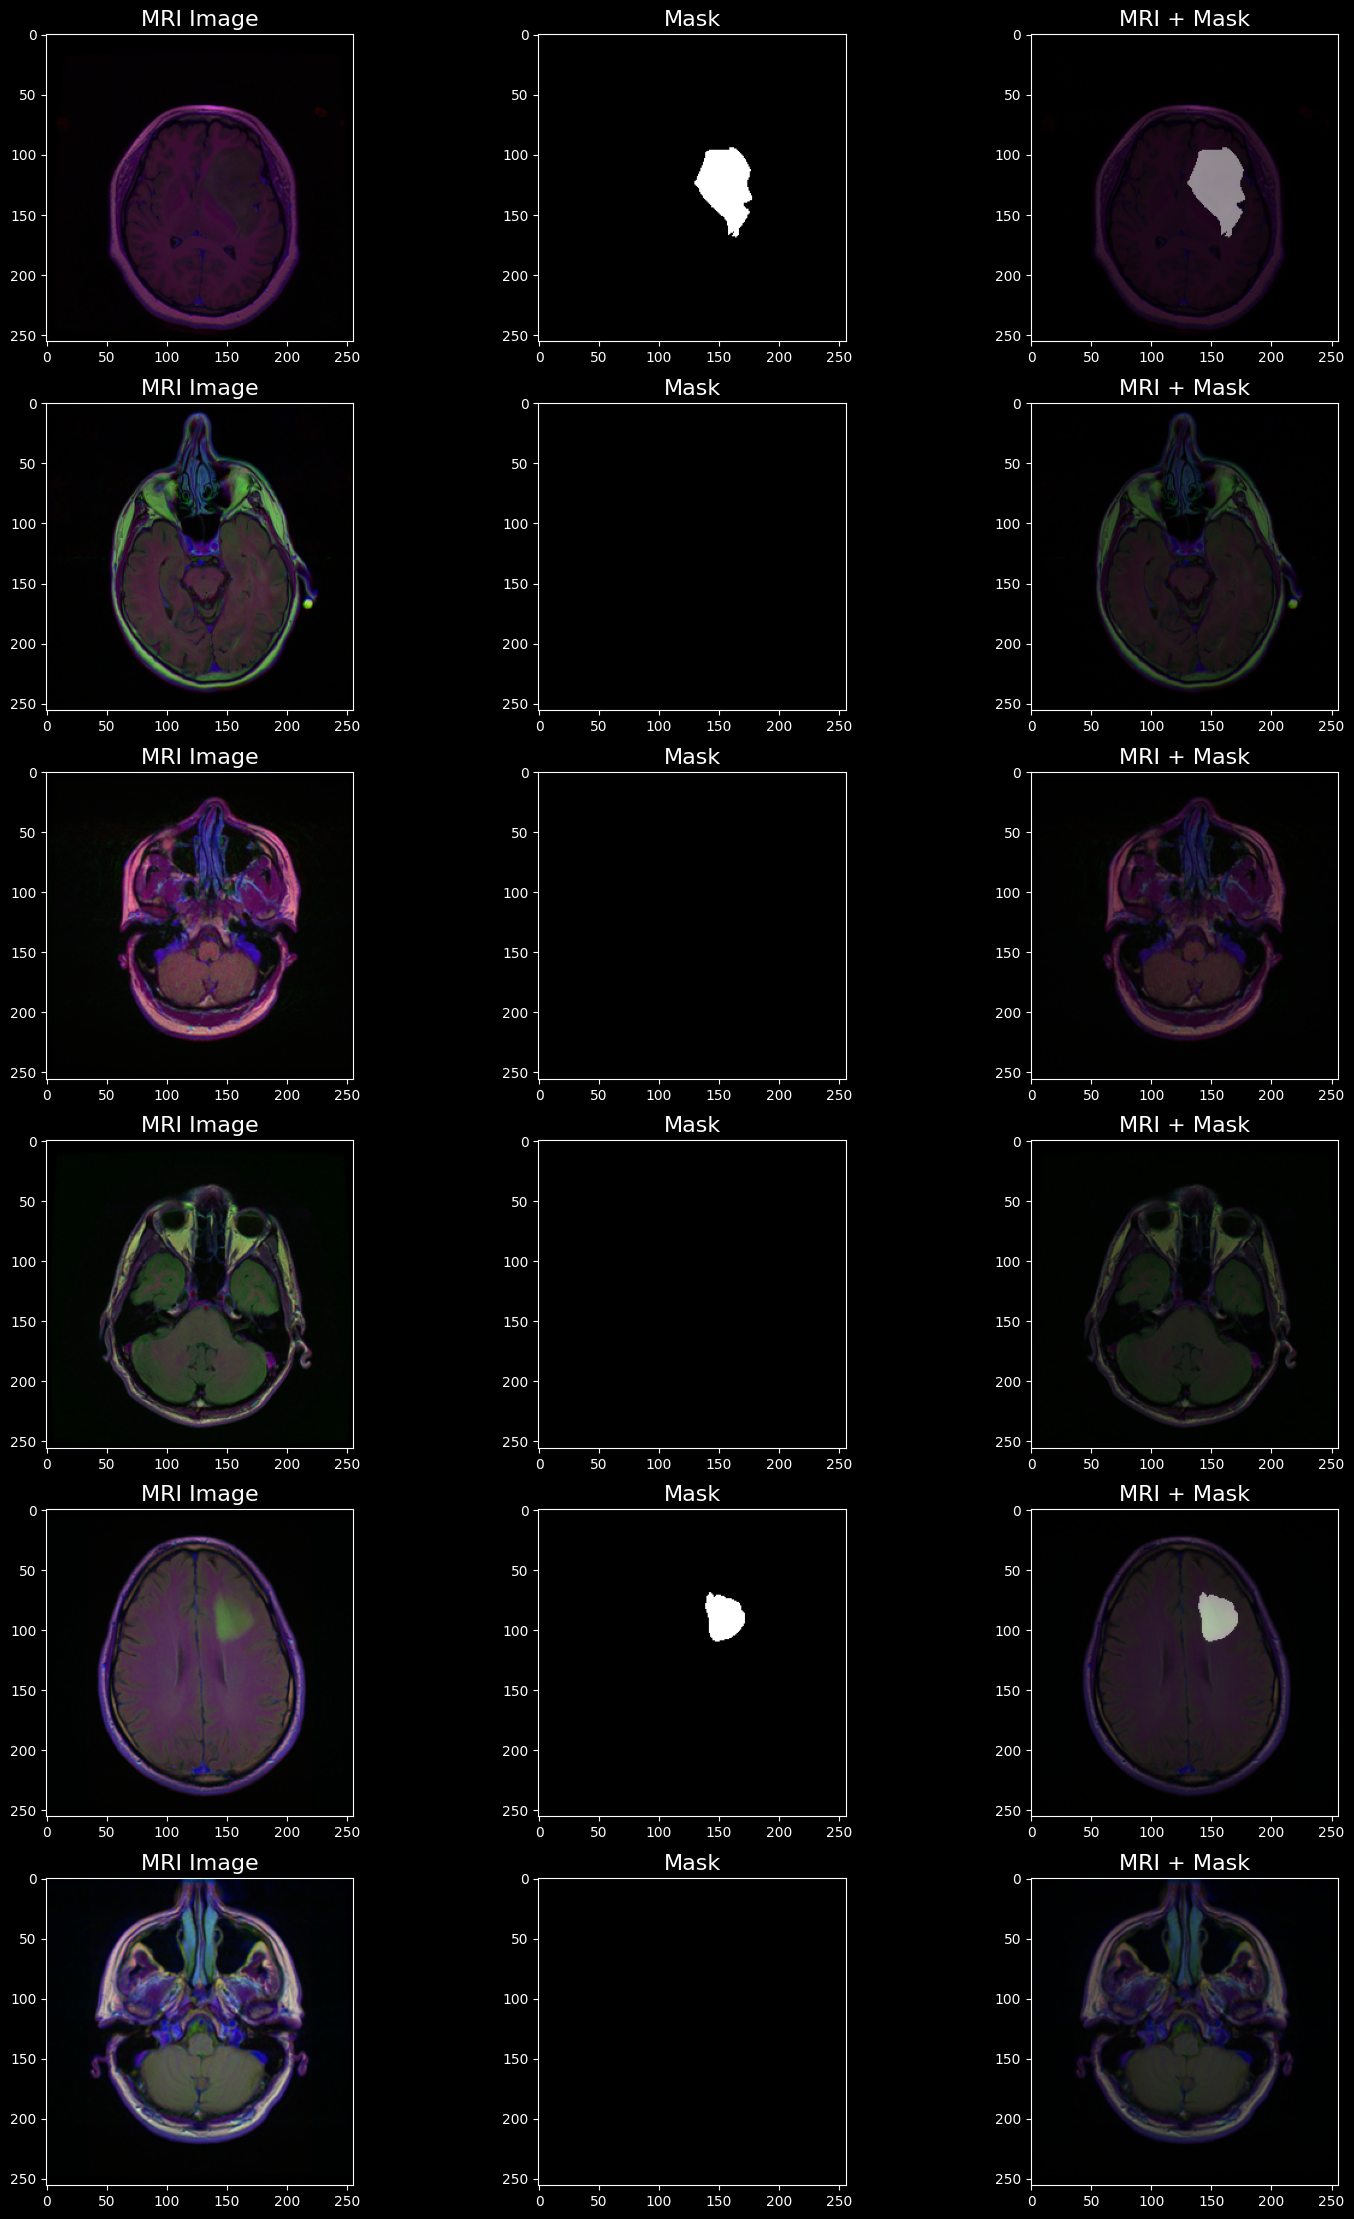

In [117]:
def view_mulitiple_samples(df, sample_loader, count=10, color_map='rgb', fig_size=(14, 10), title_size=16):
    idx = random.sample(df.index.to_list(), count)
    
    fig = plt.figure(figsize=fig_size);
    fig.tight_layout();
    fig.subplots_adjust(top=0.95);

    for row, _ in enumerate(idx):
        image, mask = (
            sample_loader(df.image_path[_]),#.permute(1, 2, 0),
            sample_loader(df.mask_path[_])#.permute(1, 2, 0)
        )
        
        idx = 3 * (row + 1)
        # Plot MRI Image
        plt.subplot(count+1, 3, idx + 1);
        plt.title(f'MRI Image', fontsize=title_size);
        if color_map=='rgb':
            plt.imshow(image)
        else:
            plt.imshow(image, cmap=color_map)

        # Plot Mask
        plt.subplot(count+1, 3, idx + 2);
        plt.title(f'Mask', fontsize=title_size)
        plt.imshow(mask, cmap='gray');

        # Plot MRI w. Mask 
        plt.subplot(count+1, 3, idx + 3);
        plt.title(f'MRI + Mask', fontsize=title_size)
        if color_map=='rgb':
            plt.imshow(image)
        else:
            plt.imshow(image, cmap=color_map)

        plt.imshow(mask, cmap='gray', alpha=0.5);

    return

# View 6 random sample images
view_mulitiple_samples(
    ds, _load, 
    count=6, color_map='mako',
    fig_size=(18, 30)
)

<a id='1.5'></a>
### Create Train, Validation and Test sets

In [118]:
# Create Train split 
train_split_idx, data_split_idx, _, _ = (
    train_test_split(
        ds.index, 
        ds.diagnosis, 
        test_size=0.30, #70 b lmia train 30 b lmia l ba9i
        stratify=ds.diagnosis, #stratify maenetha "matkhafsh, je vais garder la meme distribution ela hssab diagnosis"
        random_state=CFG.SEED
    )
)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [131]:
# Get training and remaining data
train_df = ds.iloc[train_split_idx].reset_index(drop=True)
data_df = ds.iloc[data_split_idx].reset_index(drop=True)
#ds.shape (3929, 5)

# View shapes
train_df.shape, data_df.shape

((2750, 5), (1179, 5))

In [120]:
# Create Val/Test split 
val_split_idx, test_split_idx, _, _ = (
    train_test_split(
        data_df.index, 
        data_df.diagnosis, 
        test_size=0.65,
        stratify=data_df.diagnosis,
        random_state=CFG.SEED
    )
)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [121]:
# Get training and remaining data
val_df = data_df.iloc[val_split_idx].reset_index(drop=True)
test_df = data_df.iloc[test_split_idx].reset_index(drop=True)

# View shapes (total rahou (1179, 5))
val_df.shape, test_df.shape

((412, 5), (767, 5))

In [123]:
train_size = len(train_df)
val_size = len(val_df)
test_size = len(test_df)
total = train_size + val_size + test_size

# View the counts
print(f'train samples count:\t\t{train_size}\t({(100 * train_size/total):.2f}%)')
print(f'validation samples count:\t{val_size}\t({(100 * val_size/total):.2f}%)')
print(f'test samples count:\t\t{test_size}\t({(100 * test_size/total):.2f}%)')
print('================================================')
print(f'TOTAL:\t\t\t\t{total}\t({(100 * total/total):.2f}%)')

train samples count:		2750	(69.99%)
validation samples count:	412	(10.49%)
test samples count:		767	(19.52%)
TOTAL:				3929	(100.00%)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


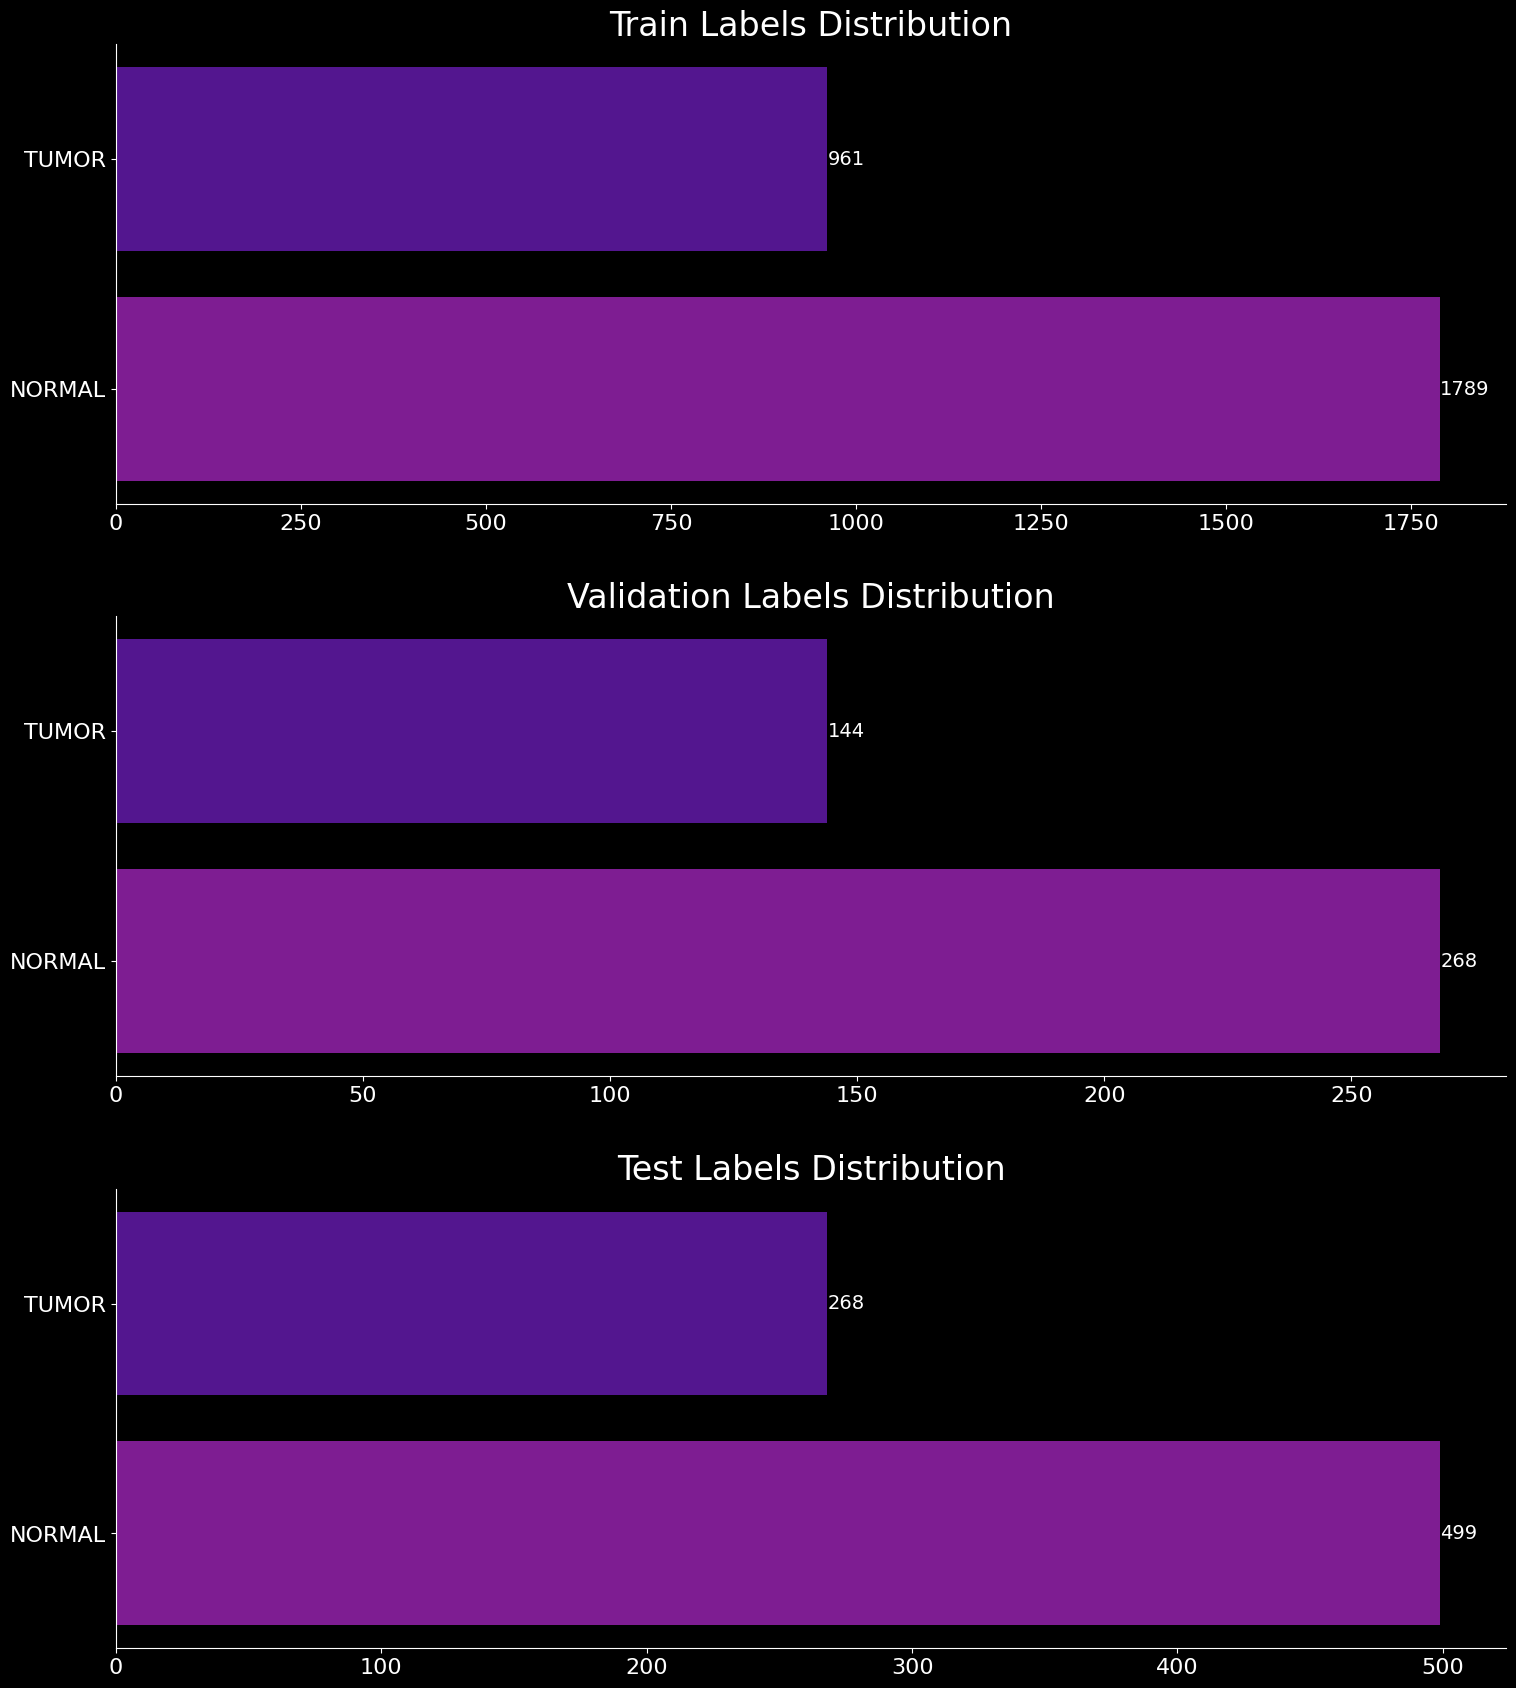

In [124]:
#HNA NDIROU PLOT L GAE LES DS BESH NCHOUFOU BELLI "Yes Indeed 93ad le stratify ela hssab Diagnosis"



fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16, 18))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)
sns.despine();


# Plot Train Labels Distribution
ax1.set_title('Train Labels Distribution', fontsize=24)
train_distribution = train_df['diagnosis'].value_counts().sort_values()
labels = {0: 'NORMAL', 1: 'TUMOR'}
bar_plot = sns.barplot(
    x=train_distribution.values,
    y=[labels[_] for _ in train_distribution.keys()],
    orient="h", palette=sns.color_palette("plasma"),
    ax=ax1
);

for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.0f', fontsize=14);

# Update axes tick parameters
ax1.tick_params(
    axis='both', which='major', 
    labelsize=16
);

# Plot Validation Labels Distribution
ax2.set_title('Validation Labels Distribution', fontsize=24)
val_distribution = val_df['diagnosis'].value_counts().sort_values()

bar_plot = sns.barplot(
    x=val_distribution.values,
    y=[labels[_] for _ in val_distribution.keys()],
    orient="h", palette=sns.color_palette("plasma"),
    ax=ax2
);

for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.0f', fontsize=14);

# Update axes tick parameters
ax2.tick_params(
    axis='both', which='major', 
    labelsize=16
);
    
# Plot Test Labels Distribution
ax3.set_title('Test Labels Distribution', fontsize=24)
test_distribution = test_df['diagnosis'].value_counts().sort_values()

bar_plot = sns.barplot(
    x=test_distribution.values,
    y=[labels[_] for _ in test_distribution.keys()],
    orient="h", palette=sns.color_palette("plasma"),
    ax=ax3
);

for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.0f', fontsize=14);
    
# Update axes tick parameters
ax3.tick_params(
    axis='both', which='major', 
    labelsize=16
);

# 2 | Build Custom Datasets & DataLoaders

### Define & Inspect Image Transforms

In [125]:
# Augment train data
train_transforms = A.Compose([
    A.Resize(CFG.HEIGHT, CFG.WIDTH, p=1.0),#LAZEM 100 pourcent yreja3ha kima les autres tae le modele
    A.RandomBrightnessContrast(p=0.2),#proba tae 0.2 ybedel la luminosite (soit ytela3 soit yhabat)
    A.HorizontalFlip(p=0.5),#proba tae 0.5 ye9lebha horizental
    A.VerticalFlip(p=0.5),#proba tae 0.5 ye9lebha vertical
    ToTensorV2(),#converts to tensor
])

# data li rani hab nepredictiha mandirelha walou a part nreje3ha same size
inference_transforms = A.Compose([
    A.Resize(CFG.HEIGHT, CFG.WIDTH, p=1.0),
    ToTensorV2(),
])

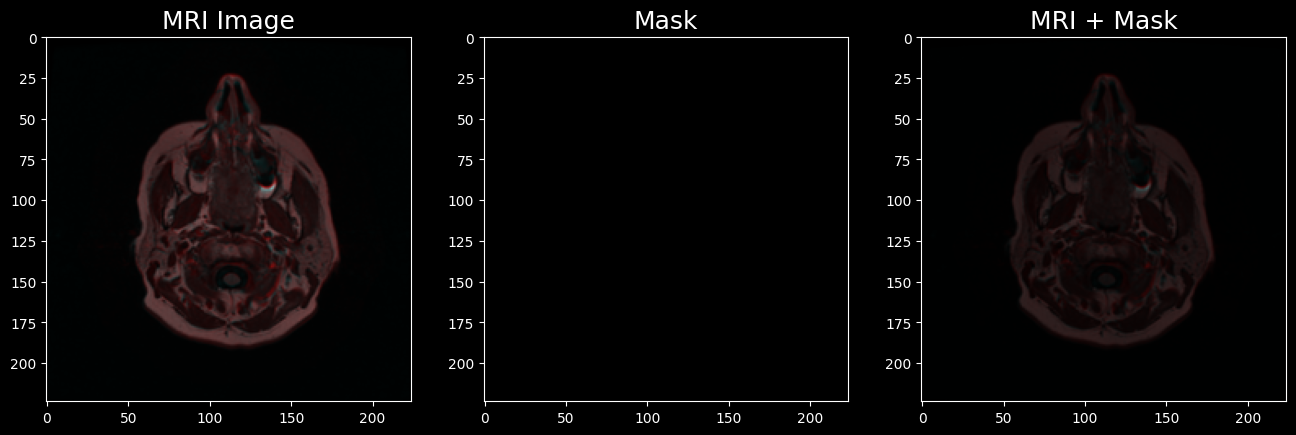

In [127]:
# Select random sample from train_df
idx = random.sample(ds.index.to_list(), 1)[0]

# Load the random sample and label
sample_image, sample_mask = _load(ds.image_path[idx]), _load(ds.mask_path[idx])

aug = train_transforms(image=sample_image, mask=sample_mask)

# View the random sample
view_sample(
    aug['image'].permute(1, 2, 0), #tqrtib tae tensor lqzem ykoun haka
    aug['mask'].unsqueeze_(0).permute(1, 2, 0),
    color_map='mako',
)

In [ ]:
class MRISegmetationDataset(Dataset):
    #transformi les images w les masks l des listes python w y apply transform ida kayen (optionnel)
    def __init__(self, df:pd.DataFrame, transform=None) -> None:
        super().__init__()
        
        self.mri_paths = df['image_path'].to_list()
        self.mask_paths = df['mask_path'].to_list()
#         self.labels = df['diagnosis'].to_list()
        self.transform = transform
        
#         self.classes = sorted(list(df['diagnosis'].unique()))
#         self.class_to_idx = {cls_name: _ for _, cls_name in enumerate(self.classes)}
        #yloadi les normalised arrays tae images and masks ela hsab l'index en entree 
    def load_sample(self, index:str) -> Image.Image:
        image_path = self.mri_paths[index]
        mask_path = self.mask_paths[index]
        
        image, mask = Image.open(image_path), Image.open(mask_path)
        
        image = np.array(image).astype(np.float32) / 255.
        mask = np.array(mask).astype(np.float32) / 255.
        
        return image, mask
       #length of the dataset, 
    def __len__(self) -> int:
        return self.mri_paths.__len__()
    #ida endou transform y appliyih sinon yhawel l tensor brk
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, torch.Tensor]:
        image, mask = self.load_sample(index)
        
        # Transform if necessary
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            return transformed['image'], transformed['mask'].unsqueeze_(0)
        else:
            transformed = ToTensorV2()(image=image, mask=mask)    
            return transformed['image'], transformed['mask'].unsqueeze_(0)

<a id='2.2'></a>
### Build Custom Datasets

In [ ]:
# Build train dataset
#yhawel m dataframe tae pandas ila class tae MRI kima defininaha mou9bil

train_ds = MRISegmetationDataset(
    train_df, transform=train_transforms
)

# Build validation dataset
val_ds = MRISegmetationDataset(
    val_df, transform=inference_transforms
)

# Build test dataset
test_ds = MRISegmetationDataset(
    test_df, transform=inference_transforms
)

<a id='2.3'></a>
### Build DataLoaders from Custom Datasets

In [ ]:
# Build train dataloader
train_loader = DataLoader(
    dataset=train_ds, 
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=CFG.APPLY_SHUFFLE
)

# Build validation dataloader
val_loader = DataLoader(
    dataset=val_ds, 
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=False
)

# Build test dataloader
test_loader = DataLoader(
    dataset=test_ds, 
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=False
)

## FUNCTIONS

In [ ]:
#hadi treje3elna le loss et dice tae chaque epoch de training
def execute_epoch(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:
    
    # Set model into training mode
    model.train()
    
    # Initialize train loss & accuracy
    train_loss, train_dice = 0, 0
    
    # Execute training loop over train dataloader
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        # Load data onto target device
        X, y = X.to(device), y.to(device)
        
        # Feed-forward and compute metrics
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 
        
        # Reset Gradients & Backpropagate Loss
        optimizer.zero_grad()
        loss.backward()
        
        # Update Model Gradients
        optimizer.step()
        
        # Compute Batch Metrics
        predicted_class = torch.sigmoid(y_pred)
        predicted_class = (predicted_class > 0.5).float()
        
        eps = 1e-8
        train_dice += (
            (2 * (y * predicted_class).sum() + eps) / 
            ((y + predicted_class).sum() + eps)
        ).cpu().item()
        
        
    # Compute Step Metrics
    train_loss = train_loss / len(dataloader)
    train_dice = train_dice / len(dataloader)
    
    return train_loss, train_dice

<a id='3.2'></a>
### Define Evaluation Step

In [162]:
#hadi treje3elna le loss et dice tae evaluation
def evaluate(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:
    
    # Set model into eval mode
    model.eval()
    
    # Initialize eval loss & accuracy
    eval_loss, eval_dice = 0, 0
    
    # Active inferene context manager
    with torch.inference_mode():
        # Execute eval loop over dataloader
        for batch, (X, y) in enumerate(dataloader):
            # Load data onto target device
            X, y = X.to(device), y.to(device)

            # Feed-forward and compute metrics
            y_pred = model(X)
            loss = loss_fn(y_pred, y)#ykherej loss as a float
            eval_loss += loss.item() 

            # Compute Batch Metrics
            predicted_class = torch.sigmoid(y_pred)#yetactiva hna besh yeteclassa
            predicted_class = (predicted_class > 0.5).float()
            
            eps = 1e-8
            eval_dice += (
                (2 * (y * predicted_class).sum() + eps) / 
                ((y + predicted_class).sum() + eps)
            ).cpu().item()
            
    # Compute Step Metrics
    eval_loss = eval_loss / len(dataloader)
    eval_dice = eval_dice / len(dataloader)
    
    return eval_loss, eval_dice

<a id='3.3'></a>
### Construct Training Loop

In [ ]:
def train(
    model:torch.nn.Module,
    train_dataloader:torch.utils.data.DataLoader,
    eval_dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    scheduler:torch.optim.lr_scheduler,
    loss_fn:torch.nn.Module,
    epochs:int,
    device:torch.device) -> Dict[str, List]:
    
    # Initialize training session
    session = {
        'loss'            : [],
        'dice_score'      : [],
        'eval_loss'       : [],
        'eval_dice_score' : []
    }
    
    # Training loop
    for epoch in tqdm(range(epochs)):
        # Execute Epoch
        print(f'\nEpoch {epoch + 1}/{epochs}')
        train_loss, train_dice = execute_epoch(
            model, 
            train_dataloader, 
            optimizer, 
            loss_fn, 
            device
        )
        
        # Evaluate Model
        eval_loss, eval_dice = evaluate(
            model, 
            eval_dataloader,
            loss_fn, 
            device
        )
        
        # Execute schedular step
        current_lr = 0
        if scheduler: 
            scheduler.step(eval_loss)
            current_lr = optimizer.param_groups[0]['lr']
        
        # Log Epoch Metrics
        log_text = f'loss: {train_loss:.4f} - dice_score: {train_dice:.4f} - eval_loss: {eval_loss:.4f} - eval_dice_score: {eval_dice:.4f}'
        
        if scheduler: 
            print(log_text + f' - lr: {current_lr}')
        else:
            print(log_text)
            
        # Record Epoch Metrics
        session['loss'].append(train_loss)
        session['dice_score'].append(train_dice)
        session['eval_loss'].append(eval_loss)
        session['eval_dice_score'].append(eval_dice)
        
    # Return Session Metrics
    return session

<a id='3.4'></a>
### Construct Predict Function

In [ ]:
def predict(
    model:nn.Module, 
    sample_loader:torch.utils.data.DataLoader,
    device:torch.device,
    threshold:float=0.5) -> np.ndarray:
    
    # Set model into eval mode
    model.eval()
    
    predictions = []
    
    # Active inferene context manager
    with torch.inference_mode():
        # Execute eval loop over dataloader
        for batch, (X, y) in enumerate(tqdm(sample_loader)):
            # Load data onto target device
            X, y = X.to(device), y.to(device)

            # Feed-forward and compute metrics
            y_pred = model(X) 

            # Compute Batch Metrics
            predicted_class = torch.sigmoid(y_pred)
            predicted_class = (predicted_class >= threshold).float()

            # Record prediction
            predictions.append(predicted_class.cpu().numpy())
        
    return np.vstack(predictions)

## UNET

In [ ]:
from IPython.display import HTML
html_embed = """
<iframe 
    width="700" height="400" 
    src="https://www.youtube.com/embed/81AvQQnpG4Q?si=q4jCb6CHqPWNGZ8u" 
    title="YouTube video player" frameborder="0" allow="accelerometer; 
    autoplay; clipboard-write; encrypted-media; 
    gyroscope; picture-in-picture; 
    web-share" allowfullscreen>
</iframe>
"""

HTML(f'<div align="center">{html_embed}</div>')

In [ ]:
#I think hfednaha by now

class DoubleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConvBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, 
            kernel_size=3, stride=1, 
            padding=1, bias=False
        )
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, 
            kernel_size=3, stride=1, 
            padding=1, bias=False
        )

        self.batchnorm1 = nn.BatchNorm2d(out_channels)
        self.batchnorm2 = nn.BatchNorm2d(out_channels)
        
        self.relu1 = nn.ReLU(inplace=True)
        self.relu2 = nn.ReLU(inplace=True)
        
        
    def forward(self, x):
        # First Convolution
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu1(x)
        
        # Second Convolution
        x = self.conv2(x)
        x = self.batchnorm2(x)
        
        return self.relu2(x)

<a id='4.2'></a>
### Implementation U-Net


In [ ]:
class UNetModel(nn.Module):
    def __init__(
        self, in_channels:int=3, 
        out_channels:int=1, 
        block_sizes:Tuple[int]=(64, 128, 256, 512)
    ):
        super(UNetModel, self).__init__()
        # Initialise model encoder & decoder using torch ModuleLists
        self.encoder, self.decoder = nn.ModuleList(), nn.ModuleList()
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        
        # Create Encoder
        for block_size in block_sizes:
            self.encoder.append(DoubleConvBlock(in_channels, block_size))
            in_channels = block_size
            
        # Create Decoder
        for block_size in block_sizes[::-1]:
            self.decoder.append(
                nn.ConvTranspose2d(2 * block_size, block_size, kernel_size=2, stride=2)
            )
            self.decoder.append(DoubleConvBlock(2 * block_size, block_size))
        
        # Create Bottleneck
        last_blocksize = block_sizes[-1]
        self.bottleneck = DoubleConvBlock(last_blocksize, 2 * last_blocksize)
        
        # Create Output Layer
        self.output_conv = nn.Conv2d(block_sizes[0], out_channels, kernel_size=1)
        
    def forward(self, x):
        concatenations = []
        concatenations.append(x)
        
        # Propagate input downstream (Encode Input)
        for encoder_layer in self.encoder:
            x = encoder_layer(x)
            concatenations.append(x)
            x = self.max_pool(x)
            
        # Execute bottleneck
        x = self.bottleneck(x)
        concatenations = concatenations[::-1]
        
        # Propagate input upstream (Decode Input) & concatenate layers
        for _ in range(0, len(self.decoder), 2):
            x = self.decoder[_](x)
            encoder_layer = concatenations[_ // 2]
            
            # Concatenate corrensponding encoder layer to decoder layer output
            concat_layer = torch.cat(
                (encoder_layer, x), dim=1
            )
            
            x = self.decoder[_ + 1](concat_layer)
            
        # Return predicted logits    
        return self.output_conv(x)

<a id='4.3'></a>
### Generate U-Net Model

In [ ]:
# Define U-Net Params
unet_params = {
    'in_channels'    : 3,
    'out_channels'   : 1,
    'block_sizes'    : (64, 128, 256, 512)
}

# Generate Model & Push to Device
unet_model = UNetModel(**unet_params).to(CFG.DEVICE)

# If using GPU T4 x2 setup, use this:
if CFG.NUM_DEVICES > 1:
    unet_model = nn.DataParallel(unet_model)

In [ ]:
# View model summary
summary(
    model=unet_model, 
    input_size=(CFG.BATCH_SIZE, CFG.CHANNELS, CFG.WIDTH, CFG.HEIGHT),
    col_names=["output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

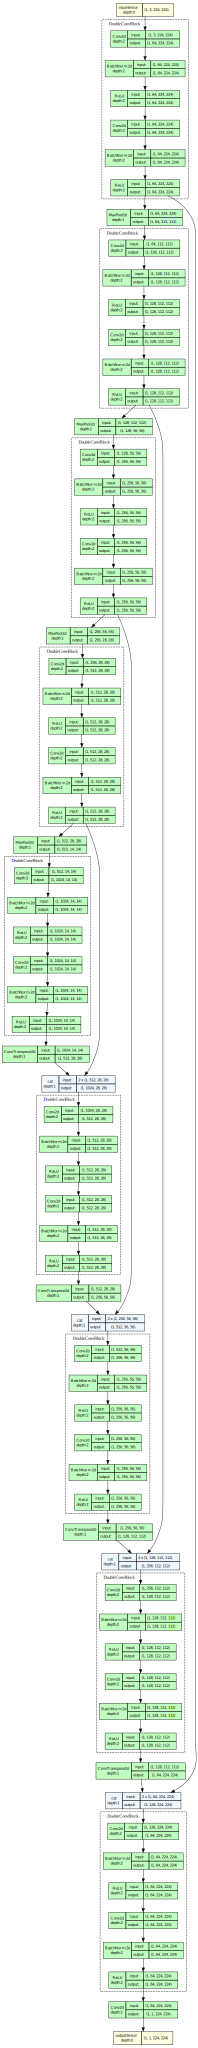

In [163]:
# Generate Model Computation Graph
model_graph = draw_graph(
    UNetModel(), 
    input_size=(1, CFG.CHANNELS, CFG.WIDTH, CFG.HEIGHT), 
    expand_nested=True
)

# View Model Architecture
model_graph.visual_graph

<a id='4.4'></a>
### Initiate Model Loss, Optimizer & LR Scheduler

In [ ]:
# Define Loss Function
loss_fn = nn.BCEWithLogitsLoss()

# Define Optimizer
optimizer = torch.optim.AdamW(
    unet_model.parameters(),
    lr=CFG.LR
)

# Define Scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, 
    mode='min',
    patience=CFG.PATIENS,
    verbose=True
)

<a id='4.5'></a>
### Train U-Net Model

In [ ]:
print('Training U-Net Model')
print(f'Train on {len(train_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

# Generate training session config 
session_config = {
    'model'               : unet_model,
    'train_dataloader'    : train_loader,
    'eval_dataloader'     : val_loader,
    'optimizer'           : optimizer,
    'scheduler'           : scheduler,
    'loss_fn'             : loss_fn,
    'epochs'              : CFG.EPOCHS,
    'device'              : CFG.DEVICE
}

# Execute Training Session
unet_session_history = train(**session_config)

In [ ]:
# Create Model directory
model_name = 'unet_model'
model_path = '/kaggle/working/model/'
os.mkdir(model_path)

In [ ]:
# Save Model 
torch.save(unet_model, model_path + model_name + '.pth')

In [ ]:
# Generate Test Masks
unet_test_masks = predict(
    unet_model, test_loader, 
    CFG.DEVICE, threshold=0.5
)

### FACTEURS PROUVANT L'EFFICACITE DU MODELE

In [ ]:
# Convert U-Net history dict to DataFrame
unet_session_history_df = pd.DataFrame(unet_session_history)
unet_session_history_df

In [164]:
# def accuracy(y_true, y_pred):
#     intersection = (y_true * y_pred).sum()
#     union = (y_true + y_pred).sum() - intersection
#     xor = (y_true == y_pred).sum()
    
#     return (xor / (union + xor - intersection))


def precision_(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    total_predicted_pixels = y_pred.sum()
    return (intersection / total_predicted_pixels).mean()


def recall_(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    total_true_pixels = y_true.sum()
    return (intersection / total_true_pixels).mean()


def dice_score(y_true, y_pred):
    eps = 1e-8
    intersection = (y_true * y_pred).sum()
    summation = (y_true + y_pred).sum()
    
    return ((2 * intersection) / (summation + eps))


def jaccard_index(y_true, y_pred):
    eps = 1e-8
    intersection = (y_true * y_pred).sum()
    union = (y_true + y_pred).sum() - intersection
    
    return (intersection / (union + eps))

In [165]:
def compute_metrics(
    model:nn.Module, 
    sample_loader:torch.utils.data.DataLoader,
    device:torch.device) -> np.ndarray:
    
    # Initiate Metrics Dict
    metrics = {
        'accuracy'      : [],
        'precision'     : [],
        'recall'        : [],
        'dice_score'    : [],
        'IoU'           : []
    }
    
    # Set model into eval mode
    model.eval()
    
    # Active inferene context manager
    with torch.inference_mode():
        # Execute eval loop over dataloader
        for batch, (X, y) in enumerate(tqdm(sample_loader)):
            # Load data onto target device
            X, y = X.to(device), y.to(device)

            # Feed-forward Input
            y_pred = model(X) 
            
            # Generate Predicted Masks
            predicted_class = torch.sigmoid(y_pred)
            predicted_class = (predicted_class > 0.3).float()
            
            # Compute Batch Metrics For Each Mask
            for true_mask, pred_mask in zip(y, predicted_class):
                acc = ((true_mask == pred_mask).sum() / torch.numel(true_mask)).cpu().item()
                prec = precision_(true_mask, pred_mask).cpu().item()
                rec = recall_(true_mask, pred_mask).cpu().item()
                dice = dice_score(true_mask, pred_mask).cpu().item()
                iou = jaccard_index(true_mask, pred_mask).cpu().item()
                
                # Record metrics
                metrics['accuracy'].append(acc)
                metrics['precision'].append(prec)
                metrics['recall'].append(rec)
                metrics['dice_score'].append(dice)
                metrics['IoU'].append(iou)
        
    return metrics

In [166]:
# Generate Segmentation Metrics
unet_metrics = compute_metrics(
    unet_model, test_loader, CFG.DEVICE
)

  0%|          | 0/12 [00:00<?, ?it/s]

In [167]:
unet_metrics

{'accuracy': [0.9974290132522583,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.9901944994926453,
  0.99613356590271,
  1.0,
  0.9984853267669678,
  0.9964524507522583,
  1.0,
  1.0,
  0.9896364808082581,
  1.0,
  1.0,
  0.9982461333274841,
  1.0,
  0.9829001426696777,
  0.9923867583274841,
  0.9921875,
  1.0,
  1.0,
  1.0,
  1.0,
  0.9948779940605164,
  1.0,
  0.9960737824440002,
  1.0,
  0.9945790767669678,
  0.9978276491165161,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.9943398833274841,
  1.0,
  0.9958944320678711,
  1.0,
  0.9973293542861938,
  1.0,
  1.0,
  0.99906325340271,
  0.9846540093421936,
  1.0,
  0.9871850609779358,
  1.0,
  0.9981664419174194,
  0.9962332248687744,
  1.0,
  0.9871452450752258,
  1.0,
  1.0,
  1.0,
  0.9985849857330322,
  0.999043345451355,
  0.9960538744926453,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.998066782951355,
  1.0,
  1.0,
  1.0,
  0.9917490482330322,
  0.9942800998687744,
  0.9943598508834839,


In [ ]:
# Create copy of test df
unet_test_df = test_df.copy()

# Concatenate Metrics onto copied df
unet_test_df = pd.concat(
    (unet_test_df, pd.DataFrame(unet_metrics)), 
    axis=1
)

# Generate diagnosis labels
unet_test_df['model_diagnosis'] = [
    int(mask.max()) for mask in unet_test_masks
]

# View df
unet_test_df

In [ ]:
# Get segmentation metrics for all samples
overall_metrics = dict(
    unet_test_df[unet_metrics.keys()]
    .mean()
)

# Get segmentation metrics for non-diagnosed samples
non_diagnosed_metrics = dict(
    unet_test_df[
        unet_test_df['diagnosis'] == 0
    ][unet_metrics.keys()].mean()
)

# Get segmentation metrics for diagnosed samples
diagnosed_metrics = dict(
    unet_test_df[
        unet_test_df['diagnosis'] == 1
    ][unet_metrics.keys()].mean()
)

# Compile metrics into dataframe
segmetation_metrics = pd.DataFrame({
    'overall_metrics': overall_metrics,
    'non_diagnosed_metrics': non_diagnosed_metrics,
    'diagnosed_metrics': diagnosed_metrics,  
}).T

# View segmetation metrics df
segmetation_metrics

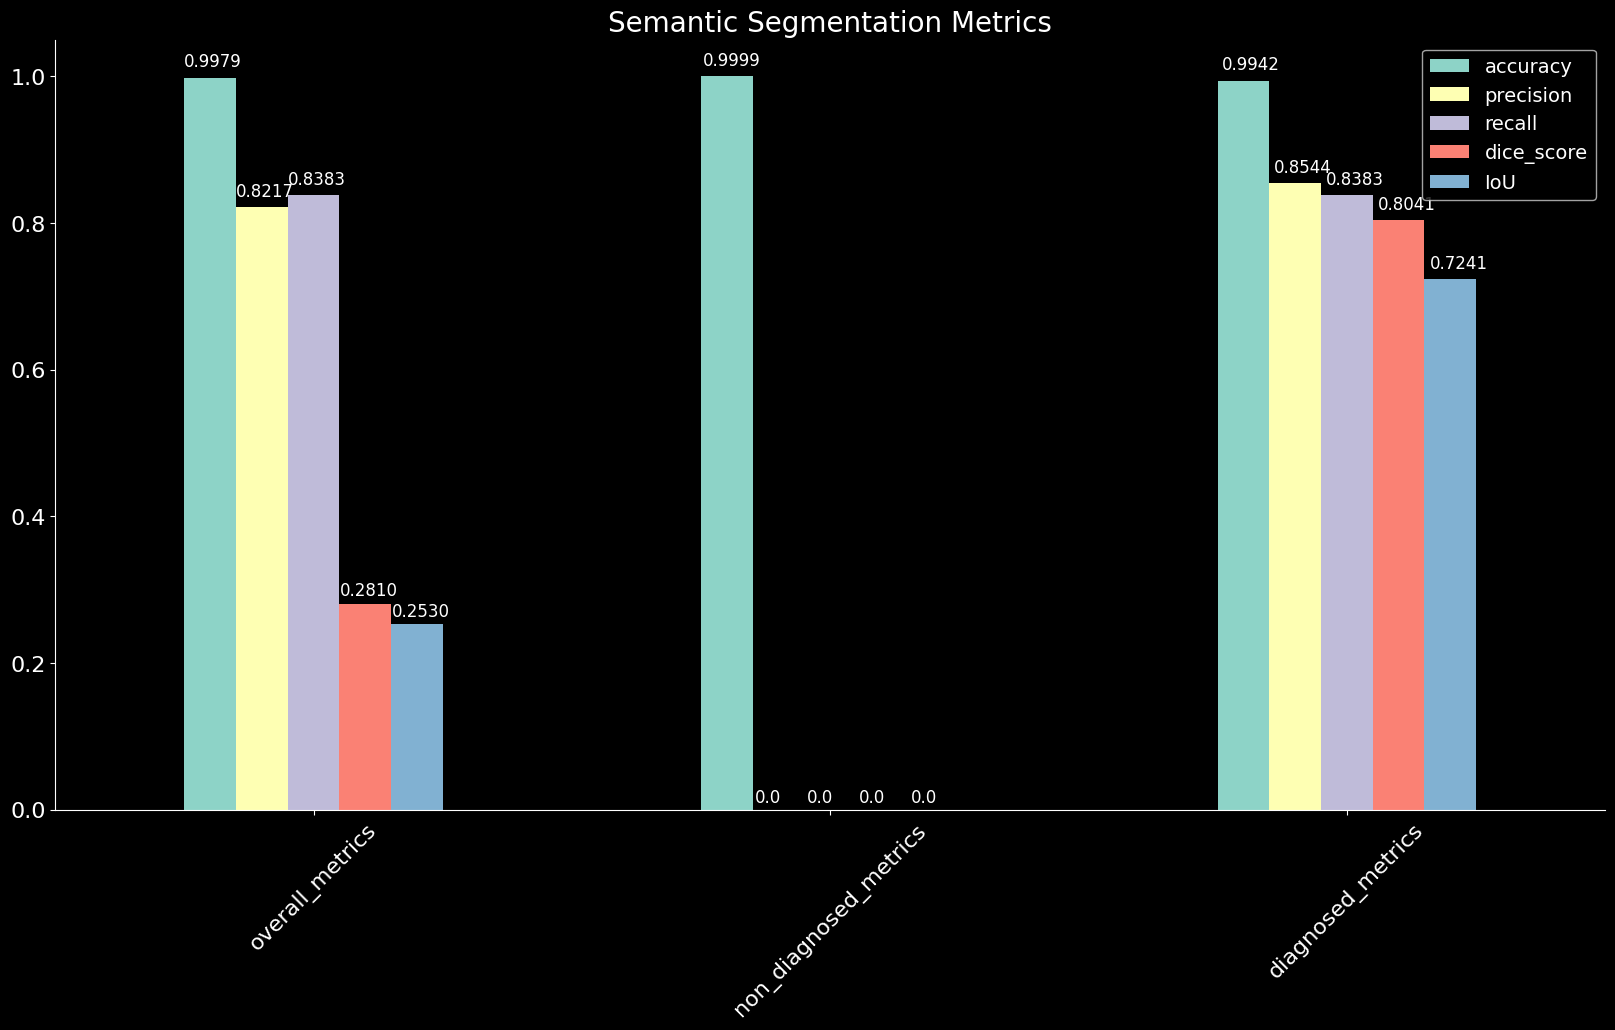

In [168]:
# Plot segmentation metrics bar plot
ax = segmetation_metrics.plot(
    kind="bar", rot=0,
    figsize=(20, 10)
)

# Add legend
ax.legend(bbox_to_anchor=(1.0, 1.0), fontsize=14)

# Display bar values
for p in ax.patches:
    bar_value = p.get_height()
    text = '0.0' if bar_value==0 else f'{bar_value:.4f}'
    ax.annotate(
        text, 
        (p.get_x() * 1.005, p.get_height() * 1.005 + 0.01), 
        fontsize=12
    )

# Update axes tick parameters
ax.tick_params(
    axis='both', which='major', 
    labelsize=16
);

# Rotate x-axis ticks
ax.tick_params(
    axis='x', which='major', 
    labelsize=16, rotation=45
);

# Add title & remove top and right borders w. sns.despine
plt.title('Semantic Segmentation Metrics', fontsize=20);
sns.despine();

<a id='5.3'></a>
### Generate Diagnosis Confusion Matrix

In [171]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12): 
    # Generate confusion matrix 
    cm = confusion_matrix(y_true, y_pred)
    
    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=0.5, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)
    
    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20) 
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0) 

    # Plot confusion matrix
    plt.show()
    


In [172]:
# Get Test True Diagnosis Labels
test_labels = unet_test_df['diagnosis'].to_numpy()

# Get Test Predicted Diagnosis Labels
unet_predictions = unet_test_df['model_diagnosis'].to_numpy()

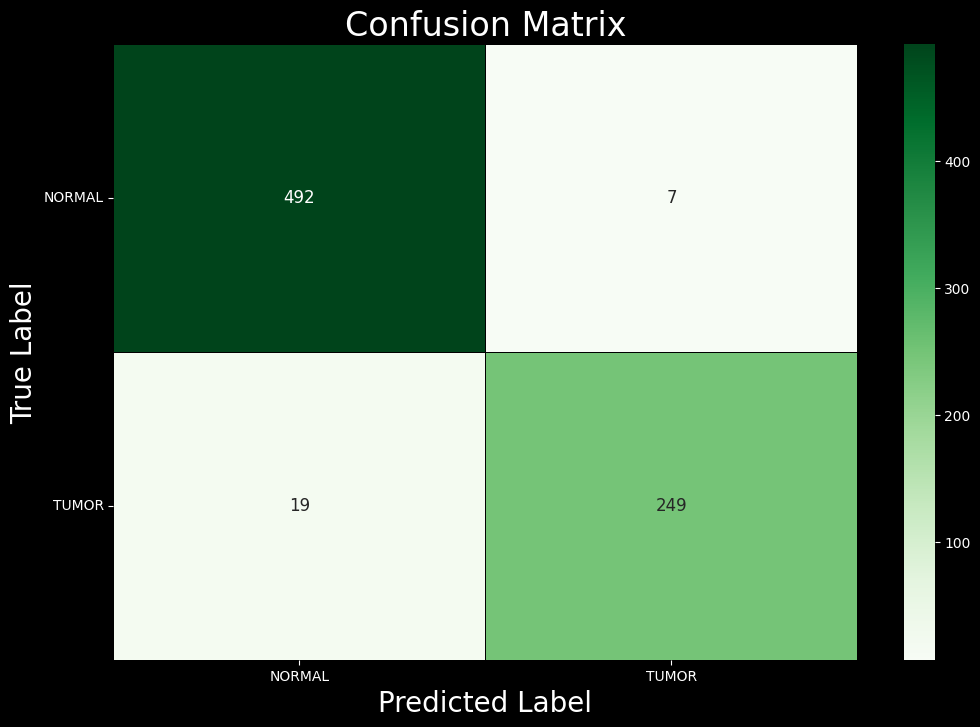

In [173]:
# Plot Confusion Matrix
plot_confusion_matrix(
    test_labels, 
    unet_predictions, 
    figsize=(12, 8),  
    classes=['NORMAL', 'TUMOR']
)

<a id='5.4'></a>
### Inspect Diagnosis Classification Metrics

In [174]:
print(
    classification_report(
        test_labels, 
        unet_predictions, 
        target_names=['NORMAL', 'TUMOR']
))

              precision    recall  f1-score   support

      NORMAL       0.96      0.99      0.97       499
       TUMOR       0.97      0.93      0.95       268

    accuracy                           0.97       767
   macro avg       0.97      0.96      0.96       767
weighted avg       0.97      0.97      0.97       767



In [158]:
def generate_performance_scores(y_true, y_pred, log=True):
    
    model_accuracy = accuracy_score(y_true, y_pred)
    model_precision, model_recall, model_f1, _ = (
        precision_recall_fscore_support(
            y_true, y_pred, average="weighted"
        )
    )    
    model_matthews_corrcoef = matthews_corrcoef(y_true, y_pred)
    
    if log:
        print('=============================================')
        print(f'\nPerformance Metrics:\n')
        print('=============================================')
        print(f'accuracy_score:\t\t{model_accuracy:.4f}\n')
        print('_____________________________________________')
        print(f'precision_score:\t{model_precision:.4f}\n')
        print('_____________________________________________')
        print(f'recall_score:\t\t{model_recall:.4f}\n')
        print('_____________________________________________')
        print(f'f1_score:\t\t{model_f1:.4f}\n')
        print('_____________________________________________')
        print(f'matthews_corrcoef:\t{model_matthews_corrcoef:.4f}\n')
        print('=============================================')
    
    preformance_scores = {
        'accuracy_score'       : model_accuracy,
        'precision_score'      : model_precision,
        'recall_score'         : model_recall,
        'f1_score'             : model_f1,
        'matthews_corrcoef'    : model_matthews_corrcoef
    }
    return preformance_scores

In [159]:
# Generate U-Net model classification performance scores
unet_model_performance = generate_performance_scores(
    test_labels, unet_predictions, log=True
)


Performance Metrics:

accuracy_score:		0.9661

_____________________________________________
precision_score:	0.9663

_____________________________________________
recall_score:		0.9661

_____________________________________________
f1_score:		0.9659

_____________________________________________
matthews_corrcoef:	0.9252



<a id='5.5'></a>
### View Diagnosed Sample Prediction Masks

In [175]:
def view_multiple_predictions(
    model, ds, count=10, 
    color_map='rgb', 
    fig_size=(14, 10), 
    title_size=16):
    
    # Select random samples
    idx = random.sample(
        list(range(len(ds))), 
        count
    )
    
    # Initialise figure
    fig = plt.figure(figsize=fig_size);
    fig.tight_layout();
    fig.subplots_adjust(top=0.95);
    
    # Plot Samples 
    for row, _ in enumerate(idx):
        image, mask = ds[_]
        idx = 3 * (row + 1)
        
        # Plot MRI Image
        plt.subplot(count+1, 3, idx + 1);
        plt.title(f'MRI Image', fontsize=title_size);
        if color_map=='rgb':
            plt.imshow(image.permute(1, 2, 0))
        else:
            plt.imshow(image.permute(1, 2, 0), cmap=color_map)

        # Plot Mask
        plt.subplot(count+1, 3, idx + 2);
        plt.title(f'True Mask', fontsize=title_size)
        plt.imshow(mask.permute(1, 2, 0), cmap='gray');

        # Generate predicted mask
        mri_input = torch.unsqueeze(
            torch.tensor(image), dim=0
        )
        
        # Set inferene context manager to active for predictions
        with torch.inference_mode():
            pred_mask = model(mri_input)
            pred_mask = torch.sigmoid(pred_mask).cpu()
            pred_mask = (pred_mask > 0.5) #threshold of 0.5

        # Plot Predicted Mask 
        plt.subplot(count+1, 3, idx + 3);
        plt.title(f'Predicted Mask', fontsize=title_size)
        
        plt.imshow(pred_mask[0].permute(1, 2, 0), cmap='gray');

    return

In [176]:
# Create Dataset for Diagnosed Sample
test_diagnosed_ds = MRISegmetationDataset(
    unet_test_df[
        unet_test_df['diagnosis'] == 1
    ].reset_index(drop=True), 
    transform=inference_transforms
)

In [ ]:
# View Random Samples
view_multiple_predictions(
    unet_model, test_diagnosed_ds, 
    count=8, color_map='rgb',
    fig_size=(20, 38)
)

## Test predictions of saved model

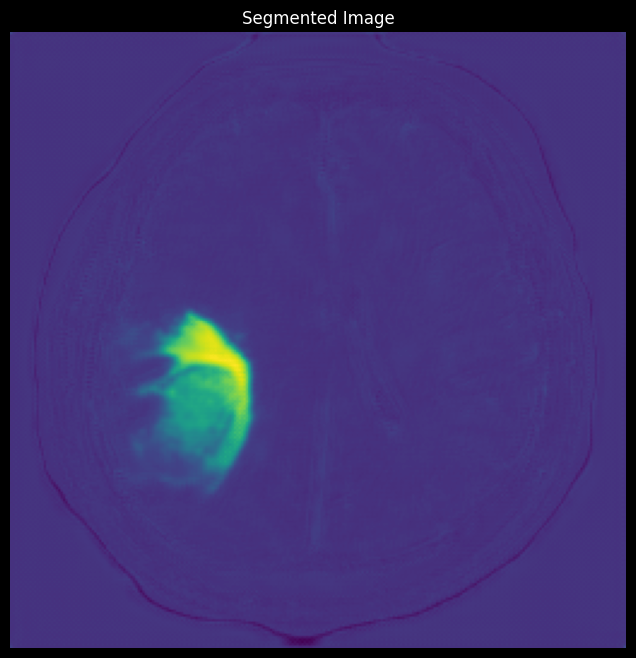

In [177]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Function to load the model
def load_model(model_path):
    # Load the saved model
    loaded_model = torch.load(model_path, map_location=torch.device('cpu'))

    if isinstance(loaded_model, torch.nn.DataParallel):
        model = loaded_model.module
    else:
        model = loaded_model
    
    model.eval()  # Set the model to evaluation mode
    return model

# Function to perform segmentation on an image
def segment_image(model, image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    
    preprocess = A.Compose([
        A.Resize(256, 256, p=1.0),  # Replace with your desired size
        ToTensorV2(),
    ])

    augmented = preprocess(image=np.array(image))
    input_tensor = augmented['image']

    # Ensure the input image has 3 channels (RGB)
    if input_tensor.shape[0] != 3:
        input_tensor = input_tensor[:3]  # Take the first 3 channels

    # Reshape and normalize if needed
    input_tensor = input_tensor.float() / 255.0  # Normalize between 0 and 1

    input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

    # Perform inference
    with torch.no_grad():
        output = model(input_batch)
    
    # Post-process the output (if needed)
    # (For example, convert tensor output to numpy array)
    segmented_image = output.squeeze().cpu().numpy()  # Ensure moving data to CPU before conversion

    return segmented_image

# Load your saved model
model_path = '/kaggle/working/model/unet_model.pth'  # Replace with your model path
your_loaded_model = load_model(model_path)

# Path to the image you want to segment
image_path_to_segment = '/kaggle/input/imageofbrain/tutu.png'  # Replace with your image path

# Perform segmentation
segmented_image_result = segment_image(your_loaded_model, image_path_to_segment)

# Now, 'segmented_image_result' contains the segmented image (output) from your model
# Further processing might be needed based on your output format and requirements
# Perform segmentation
segmented_image_result = segment_image(your_loaded_model, image_path_to_segment)

# Visualize the segmented image
plt.figure(figsize=(8, 8))
plt.imshow(segmented_image_result, cmap='viridis')  # Use a colormap suitable for your output
plt.axis('off')  # Turn off axis labels
plt.title('Segmented Image')
plt.show()


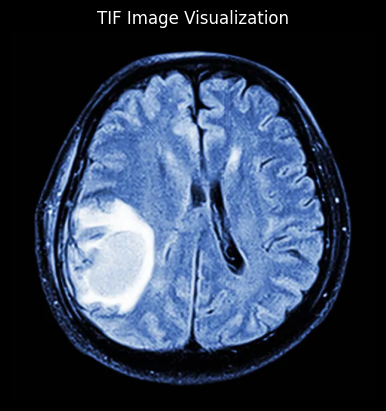

In [157]:
import matplotlib.pyplot as plt
from PIL import Image

def visualize_tif_image(image_path):
    # Load the TIFF image using PIL
    image = Image.open(image_path)

    # Display the image using Matplotlib
    plt.imshow(image, cmap='gray')  # Use 'cmap' for color mapping if needed
    plt.axis('off')  # Turn off axis labels
    plt.title('TIF Image Visualization')
    plt.show()

# Provide the path to your .tif image
tif_image_path = '/kaggle/input/imageofbrain/tutu.png'  # Replace with your image path
visualize_tif_image(tif_image_path)
